# Evaluation

known orientations are filtered using EKF and UKF, and then compared to the ground truth 


In [1]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error
import pandas as pd
import os
import numpy as np
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import matplotlib.pyplot as plt
import math

rotation_x_file_path = "../utils/servo_rotation_data_90/rotation_x.csv"
rotation_y_file_path = "../utils/servo_rotation_data_90/rotation_y.csv"
rotation_z_file_path = "../utils/servo_rotation_data_90/rotation_z.csv"

full_rotation_x_file_path = os.path.join(os.getcwd(), rotation_x_file_path)
full_rotation_y_file_path = os.path.join(os.getcwd(), rotation_y_file_path)
full_rotation_z_file_path = os.path.join(os.getcwd(), rotation_z_file_path)


# Checking if the path exists
if not os.path.exists(full_rotation_x_file_path) or not os.path.exists(full_rotation_y_file_path) or not os.path.exists(full_rotation_z_file_path):
    print(f"File(s) not found")
else:
    print(f"Found files")

df_x = pd.read_csv(full_rotation_x_file_path)
df_y = pd.read_csv(full_rotation_y_file_path)
df_z = pd.read_csv(full_rotation_z_file_path)

acc_x = np.array([df_x['Accel_X'], df_x['Accel_Y'], df_x['Accel_Z']]).T
mag_x = np.array([df_x['Magneto_X'], df_x['Magneto_Y'], df_x['Magneto_Z']]).T
gyr_x = np.array([df_x['Gyro_X'], df_x['Gyro_Y'], df_x['Gyro_Z']]).T
q_x = np.array([df_x['Quaternion_W'], df_x['Quaternion_X'], df_x['Quaternion_Y'], df_x['Quaternion_Z']]).T

acc_y = np.array([df_y['Accel_X'], df_y['Accel_Y'], df_y['Accel_Z']]).T
mag_y = np.array([df_y['Magneto_X'], df_y['Magneto_Y'], df_y['Magneto_Z']]).T
gyr_y = np.array([df_y['Gyro_X'], df_y['Gyro_Y'], df_y['Gyro_Z']]).T
q_y = np.array([df_y['Quaternion_W'], df_y['Quaternion_X'], df_y['Quaternion_Y'], df_y['Quaternion_Z']]).T

acc_z = np.array([df_z['Accel_X'], df_z['Accel_Y'], df_z['Accel_Z']]).T
mag_z = np.array([df_z['Magneto_X'], df_z['Magneto_Y'], df_z['Magneto_Z']]).T
gyr_z = np.array([df_z['Gyro_X'], df_z['Gyro_Y'], df_z['Gyro_Z']]).T
q_z = np.array([df_z['Quaternion_W'], df_z['Quaternion_X'], df_z['Quaternion_Y'], df_z['Quaternion_Z']]).T

dim_x = 4
dim_z = 4
points = MerweScaledSigmaPoints(n=dim_x, alpha=0.1, beta=2.0, kappa=0.0)
ukf = UKF(dim_x=dim_x, dim_z=dim_z, fx=lambda x, dt: x, hx=lambda x: x, dt=1/25, points=points)
ukf.x = np.array([1, 0, 0, 0])  # Initial state
ukf.P *= 0.1  # Initial covariance

Found files


In [2]:
import numpy as np
from scipy.spatial.transform import Rotation
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians

class QuaternionEKF:
    def __init__(self):
        # state vector: [p, q, r, a, b, c, d]
        # p,q,r are angular rates
        # a,b,c,d are quaternion components
        self.state = np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0])
        
        # state covariance
        self.P = np.eye(7) * 0.1

        # process noise
        self.Q = np.eye(7)
        self.Q[:3, :3] *= 0.25  # angular rates noise
        self.Q[3:, 3:] *= 0.1  # quaternion noise
        
        # measurement noise
        self.R = np.eye(7) * 1000
        
        # system parameters
        self.dt = 0.04  # sample time
        self.tau = 0.2  # Time constant for angular rates
        
    def quaternion_multiply(self, q1, q2):
        """Multiply two quaternions"""
        w1, x1, y1, z1 = q1
        w2, x2, y2, z2 = q2
        
        return np.array([
            w1*w2 - x1*x2 - y1*y2 - z1*z2,
            w1*x2 + x1*w2 + y1*z2 - z1*y2,
            w1*y2 - x1*z2 + y1*w2 + z1*x2,
            w1*z2 + x1*y2 - y1*x2 + z1*w2
        ])
    
    def quaternion_to_rotation_matrix(self, q):
        """
        Convert quaternion to rotation matrix
        q = [q0, q1, q2, q3] = [w, x, y, z]
        """
        # Extract quaternion components
        q0, q1, q2, q3 = q
        
        # Compute rotation matrix elements
        R = np.array([
            [1 - 2*q2**2 - 2*q3**2,     2*(q1*q2 - q0*q3),     2*(q1*q3 + q0*q2)],
            [    2*(q1*q2 + q0*q3), 1 - 2*q1**2 - 2*q3**2,     2*(q2*q3 - q0*q1)],
            [    2*(q1*q3 - q0*q2),     2*(q2*q3 + q0*q1), 1 - 2*q1**2 - 2*q2**2]
        ])
        
        return R

    def quaternion_multiply(self, q1, q2):
        """
        Multiply two quaternions
        q = [q0, q1, q2, q3] = [w, x, y, z]
        """
        w1, x1, y1, z1 = q1
        w2, x2, y2, z2 = q2
        
        return np.array([
            w1*w2 - x1*x2 - y1*y2 - z1*z2,  # w
            w1*x2 + x1*w2 + y1*z2 - z1*y2,  # x
            w1*y2 - x1*z2 + y1*w2 + z1*x2,  # y
            w1*z2 + x1*y2 - y1*x2 + z1*w2   # z
        ])

    def quaternion_conjugate(self, q):
        """
        Compute quaternion conjugate
        q = [q0, q1, q2, q3] = [w, x, y, z]
        """
        return np.array([q[0], -q[1], -q[2], -q[3]])

    def rotate_vector(self, v, q):
        """
        Rotate vector v by quaternion q
        """
        # Convert vector to pure quaternion
        v_quat = np.array([0, v[0], v[1], v[2]])
        
        # Compute rotation: q * v * q^*
        q_conj = self.quaternion_conjugate(q)
        rotated = self.quaternion_multiply(
            self.quaternion_multiply(q, v_quat),
            q_conj
        )
        
        # Return vector part
        return rotated[1:]

    def compute_measurement_jacobian(self, q, acc_earth, mag_earth):
        """
        Compute Jacobian matrix for measurement model
        """
        # Initialize Jacobian matrix (6x4 for accelerometer and magnetometer)
        J = np.zeros((6, 4))
        
        # Compute Jacobian for accelerometer measurements
        q0, q1, q2, q3 = q
        
        # Accelerometer Jacobian
        J[0:3, 0] = np.array([
            2*(q0*acc_earth[0] + q3*acc_earth[1] - q2*acc_earth[2]),
            2*(q3*acc_earth[0] + q0*acc_earth[1] + q1*acc_earth[2]),
            2*(-q2*acc_earth[0] + q1*acc_earth[1] + q0*acc_earth[2])
        ])
        
        J[0:3, 1] = np.array([
            2*(q1*acc_earth[0] + q2*acc_earth[1] + q3*acc_earth[2]),
            2*(q2*acc_earth[0] - q1*acc_earth[1] - q0*acc_earth[2]),
            2*(q3*acc_earth[0] - q0*acc_earth[1] - q1*acc_earth[2])
        ])
        
        J[0:3, 2] = np.array([
            2*(-q2*acc_earth[0] + q1*acc_earth[1] + q0*acc_earth[2]),
            2*(q1*acc_earth[0] + q2*acc_earth[1] + q3*acc_earth[2]),
            2*(-q0*acc_earth[0] - q3*acc_earth[1] + q2*acc_earth[2])
        ])
        
        J[0:3, 3] = np.array([
            2*(-q3*acc_earth[0] + q0*acc_earth[1] + q1*acc_earth[2]),
            2*(q0*acc_earth[0] - q3*acc_earth[1] + q2*acc_earth[2]),
            2*(q1*acc_earth[0] + q2*acc_earth[1] + q3*acc_earth[2])
        ])
        
        # Magnetometer Jacobian (similar structure but with mag_earth)
        J[3:6, 0] = np.array([
            2*(q0*mag_earth[0] + q3*mag_earth[1] - q2*mag_earth[2]),
            2*(q3*mag_earth[0] + q0*mag_earth[1] + q1*mag_earth[2]),
            2*(-q2*mag_earth[0] + q1*mag_earth[1] + q0*mag_earth[2])
        ])
        
        J[3:6, 1] = np.array([
            2*(q1*mag_earth[0] + q2*mag_earth[1] + q3*mag_earth[2]),
            2*(q2*mag_earth[0] - q1*mag_earth[1] - q0*mag_earth[2]),
            2*(q3*mag_earth[0] - q0*mag_earth[1] - q1*mag_earth[2])
        ])
        
        J[3:6, 2] = np.array([
            2*(-q2*mag_earth[0] + q1*mag_earth[1] + q0*mag_earth[2]),
            2*(q1*mag_earth[0] + q2*mag_earth[1] + q3*mag_earth[2]),
            2*(-q0*mag_earth[0] - q3*mag_earth[1] + q2*mag_earth[2])
        ])
        
        J[3:6, 3] = np.array([
            2*(-q3*mag_earth[0] + q0*mag_earth[1] + q1*mag_earth[2]),
            2*(q0*mag_earth[0] - q3*mag_earth[1] + q2*mag_earth[2]),
            2*(q1*mag_earth[0] + q2*mag_earth[1] + q3*mag_earth[2])
        ])
        
        return J
    
    def gauss_newton_optimization(self, acc_body, mag_body, acc_earth, mag_earth, initial_quaternion):
        """
        Gauss-Newton optimization for finding optimal quaternion
        """
        q = initial_quaternion.copy()
        max_iterations = 3  # As suggested in the paper
        
        for _ in range(max_iterations):
            # Create rotation matrix from current quaternion
            R = self.quaternion_to_rotation_matrix(q)
            
            # Predict measurements in body frame
            acc_pred = R @ acc_earth
            mag_pred = R @ mag_earth
            
            # Compute error
            error_acc = acc_body - acc_pred
            error_mag = mag_body - mag_pred
            error = np.concatenate([error_acc, error_mag])
            
            # Compute Jacobian
            J = self.compute_measurement_jacobian(q, acc_earth, mag_earth)
            
            # Gauss-Newton update
            try:
                delta = np.linalg.inv(J.T @ J) @ J.T @ error
                q = q + delta
                q = q / np.linalg.norm(q)  # Normalize
            except np.linalg.LinAlgError:
                print("Warning: Singular matrix in Gauss-Newton update")
                break
                
        return q

    def predict(self):
        """Prediction step"""
        # Extract current states
        p, q, r = self.state[:3]
        quat = self.state[3:]
        
        # Angular rate model
        p_dot = -p/self.tau
        q_dot = -q/self.tau
        r_dot = -r/self.tau
        
        # Quaternion rate
        omega = np.array([0, p, q, r])
        quat_dot = 0.5 * self.quaternion_multiply(quat, omega)
        
        # Update state
        self.state[:3] += np.array([p_dot, q_dot, r_dot]) * self.dt
        self.state[3:] += quat_dot * self.dt
        
        # Normalize quaternion
        self.state[3:] /= np.linalg.norm(self.state[3:])
        
        # Compute Jacobian
        F = self.get_state_transition_matrix()
        
        # Update covariance
        self.P = F @ self.P @ F.T + self.Q
        
    def get_state_transition_matrix(self):
        """Compute state transition matrix"""
        F = np.eye(7)
        dt = self.dt
        p, q, r = self.state[:3]
        a, b, c, d = self.state[3:]
        
        # Angular rate terms
        F[:3, :3] = np.eye(3) * (1 - dt/self.tau)
        
        # Quaternion terms
        F[3:, 3:] = np.eye(4) + dt * 0.5 * np.array([
            [0, -p, -q, -r],
            [p, 0, r, -q],
            [q, -r, 0, p],
            [r, q, -p, 0]
        ])
        
        return F
    
    def update(self, measurement):
        """Update step using MARG measurements"""
        # Compute Kalman gain
        H = np.eye(7)  # Measurement matrix is identity
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # Update state
        innovation = measurement - self.state
        self.state += K @ innovation
        
        # Normalize quaternion part
        self.state[3:] /= np.linalg.norm(self.state[3:])
        
        # Update covariance
        self.P = (np.eye(7) - K @ H) @ self.P
    
    def process_measurement(self, gyro, accel, mag, quaternion):
        """Process one set of MARG sensor measurements"""
        # First predict
        self.predict()
                
        # Combine with gyro for measurement update
        measurement = np.zeros(7)
        measurement[:3] = gyro
        measurement[3:] = quaternion
        
        # Update
        self.update(measurement)
        
        return self.state.copy()
    
    def compute_orientation_quaternion(self, accel, mag):
        """Compute orientation quaternion from accelerometer and magnetometer"""
        accel = accel / np.linalg.norm(accel)
        mag = mag / np.linalg.norm(mag)

        acc_earth = np.array([0, 0, -9.81])
        mag_earth = np.array([0.22, 0, -0.44])
        # mag_earth = mag_earth / np.linalg.norm(mag_earth)
        
        self.gauss_newton_optimization(acc, mag, acc_earth, mag_earth, self.state[3:7])
        return R.as_quat()[[3,0,1,2]]  # reorder to [w,x,y,z]

In [3]:
ekf = QuaternionEKF()

predicted_UKF_x_pitch, predicted_UKF_x_roll, predicted_UKF_x_yaw = [], [], []
predicted_UKF_y_pitch, predicted_UKF_y_roll, predicted_UKF_y_yaw = [], [], []
predicted_UKF_z_pitch, predicted_UKF_z_roll, predicted_UKF_z_yaw = [], [], []

predicted_EKF_x_pitch, predicted_EKF_x_roll, predicted_EKF_x_yaw = [], [], []
predicted_EKF_y_pitch, predicted_EKF_y_roll, predicted_EKF_y_yaw = [], [], []
predicted_EKF_z_pitch, predicted_EKF_z_roll, predicted_EKF_z_yaw = [], [], []

raw_x_pitch, raw_x_roll, raw_x_yaw = [], [], []
raw_y_pitch, raw_y_roll, raw_y_yaw = [], [], []
raw_z_pitch, raw_z_roll, raw_z_yaw = [], [], []

for q in q_x:
    # UKF Code
    q = q / np.linalg.norm(q)
    ukf.predict()
    ukf.update(q)
    roll, pitch, yaw = euler_from_quaternion(ukf.x[1], ukf.x[2], ukf.x[3], ukf.x[0])
    predicted_UKF_x_pitch.append(np.degrees(pitch))
    predicted_UKF_x_roll.append(np.degrees(roll))
    predicted_UKF_x_yaw.append(np.degrees(yaw))
    
    roll, pitch, yaw = euler_from_quaternion(q[1], q[2], q[3], q[0])
    raw_x_pitch.append(np.degrees(pitch))
    raw_x_roll.append(np.degrees(roll))
    raw_x_yaw.append(np.degrees(yaw))

for q in q_y:
    # UKF Code
    q = q / np.linalg.norm(q)
    ukf.predict()
    ukf.update(q)
    roll, pitch, yaw = euler_from_quaternion(ukf.x[1], ukf.x[2], ukf.x[3], ukf.x[0])
    predicted_UKF_y_pitch.append(np.degrees(pitch))
    predicted_UKF_y_roll.append(np.degrees(roll))
    predicted_UKF_y_yaw.append(np.degrees(yaw))
    
    roll, pitch, yaw = euler_from_quaternion(q[1], q[2], q[3], q[0])
    raw_y_pitch.append(np.degrees(pitch))
    raw_y_roll.append(np.degrees(roll))
    raw_y_yaw.append(np.degrees(yaw))

for q in q_z:
    # UKF Code
    q = q / np.linalg.norm(q)
    ukf.predict()
    ukf.update(q)
    roll, pitch, yaw = euler_from_quaternion(ukf.x[1], ukf.x[2], ukf.x[3], ukf.x[0])
    predicted_UKF_z_pitch.append(np.degrees(pitch))
    predicted_UKF_z_roll.append(np.degrees(roll))
    predicted_UKF_z_yaw.append(np.degrees(yaw))
    
    roll, pitch, yaw = euler_from_quaternion(q[1], q[2], q[3], q[0])
    raw_z_pitch.append(np.degrees(pitch))
    raw_z_roll.append(np.degrees(roll))
    raw_z_yaw.append(np.degrees(yaw))

for i,row in df_x.iterrows():
    state = ekf.process_measurement(gyr_x[i], acc_x[i], mag_x[i], q_x[i])
    q = state[3:7]
    roll, pitch, yaw = euler_from_quaternion(q[1], q[2], q[3], q[0])
    predicted_EKF_x_pitch.append(np.degrees(pitch))
    predicted_EKF_x_roll.append(np.degrees(roll))
    predicted_EKF_x_yaw.append(np.degrees(yaw))

for i,row in df_y.iterrows():
    state = ekf.process_measurement(gyr_y[i], acc_y[i], mag_y[i], q_y[i])
    q = state[3:7]
    roll, pitch, yaw = euler_from_quaternion(q[1], q[2], q[3], q[0])
    predicted_EKF_y_pitch.append(np.degrees(pitch))
    predicted_EKF_y_roll.append(np.degrees(roll))
    predicted_EKF_y_yaw.append(np.degrees(yaw))

for i,row in df_z.iterrows():
    state = ekf.process_measurement(gyr_z[i], acc_z[i], mag_z[i], q_z[i])
    q = state[3:7]
    roll, pitch, yaw = euler_from_quaternion(q[1], q[2], q[3], q[0])
    predicted_EKF_z_pitch.append(np.degrees(pitch))
    predicted_EKF_z_roll.append(np.degrees(roll))
    predicted_EKF_z_yaw.append(np.degrees(yaw))

# Convert to numpy arrays
predicted_UKF_x_pitch = np.array(predicted_UKF_x_pitch)
predicted_UKF_x_roll = np.array(predicted_UKF_x_roll)
predicted_UKF_x_yaw = np.array(predicted_UKF_x_yaw)

predicted_UKF_y_pitch = np.array(predicted_UKF_y_pitch)
predicted_UKF_y_roll = np.array(predicted_UKF_y_roll)
predicted_UKF_y_yaw = np.array(predicted_UKF_y_yaw)

predicted_UKF_z_pitch = np.array(predicted_UKF_z_pitch)
predicted_UKF_z_roll = np.array(predicted_UKF_z_roll)
predicted_UKF_z_yaw = np.array(predicted_UKF_z_yaw)

predicted_EKF_x_pitch = np.array(predicted_EKF_x_pitch)
predicted_EKF_x_roll = np.array(predicted_EKF_x_roll)
predicted_EKF_x_yaw = np.array(predicted_EKF_x_yaw)

predicted_EKF_y_pitch = np.array(predicted_EKF_y_pitch)
predicted_EKF_y_roll = np.array(predicted_EKF_y_roll)
predicted_EKF_y_yaw = np.array(predicted_EKF_y_yaw)

predicted_EKF_z_pitch = np.array(predicted_EKF_z_pitch)
predicted_EKF_z_roll = np.array(predicted_EKF_z_roll)
predicted_EKF_z_yaw = np.array(predicted_EKF_z_yaw)

raw_x_pitch = np.array(raw_x_pitch)
raw_x_roll = np.array(raw_x_roll)
raw_x_yaw = np.array(raw_x_yaw)

raw_y_pitch = np.array(raw_y_pitch)
raw_y_roll = np.array(raw_y_roll)
raw_y_yaw = np.array(raw_y_yaw)

raw_z_pitch = np.array(raw_z_pitch)
raw_z_roll = np.array(raw_z_roll)
raw_z_yaw = np.array(raw_z_yaw)

# Evaluation: calculate the RMSE

The Root Mean Squared Error (RMSE) is calculated between the ground truth quaternion and the predicted quaternion:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (q_i - \hat{q}_i)^2}
$$


### 1)   90° Pitch Comparison

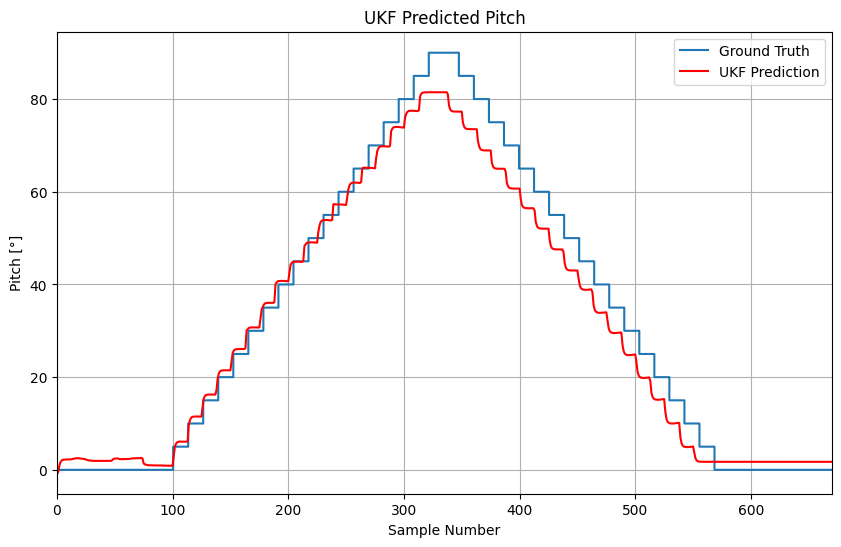

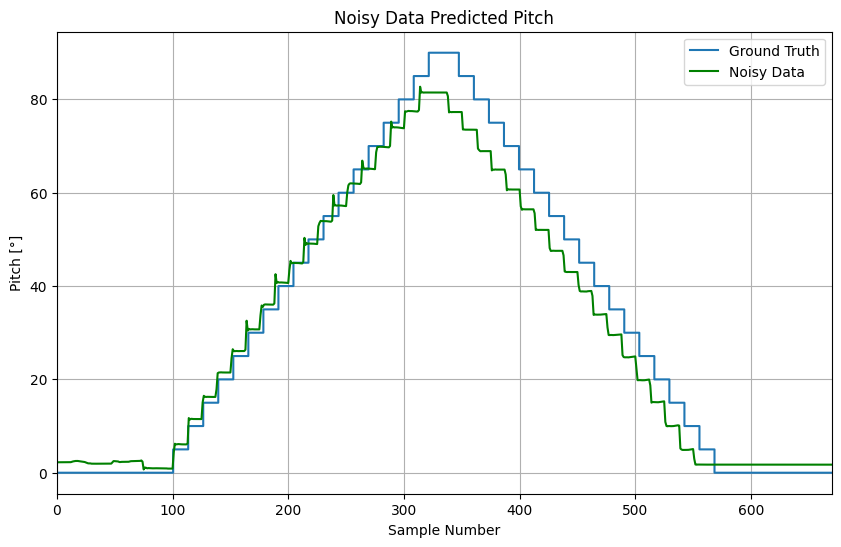

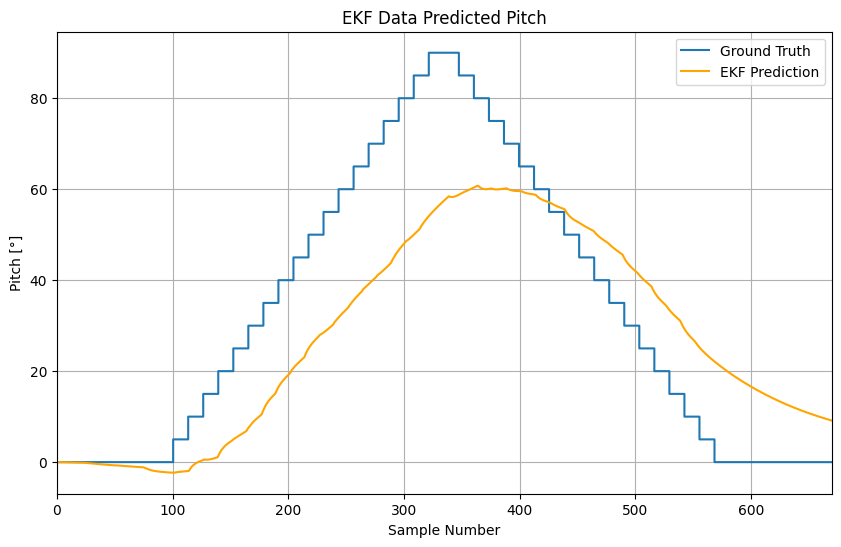

RMSE of UKF pitch :  5.0113522814329325
RMSE of EKF pitch :  17.77668858843795
RMSE of noisy data pitch :  5.162332963902692


In [8]:
time_steps = np.arange(0, 760)
increments = np.arange(0, 91, 5)
rise_values = np.concatenate([np.repeat(increments[i], 13.1) for i in range(len(increments))])
fall_values = np.concatenate([np.repeat(increments[i], 13.1) for i in range(len(increments)-1, -1, -1)])

pitch_values = np.concatenate([np.ones(88) * 0,rise_values, fall_values, np.ones(100) * 0])

time_steps = np.arange(len(pitch_values))
plt.figure(figsize=(10, 6))
plt.step(time_steps, pitch_values, where='mid', label='Ground Truth')
plt.plot(predicted_UKF_x_pitch, label='UKF Prediction', color='red')
plt.title('UKF Predicted Pitch')
plt.xlabel('Sample Number')
plt.ylabel('Pitch [°]')
plt.xlim(0,670)
plt.legend()
plt.grid(True)
plt.show()

time_steps = np.arange(len(pitch_values))
plt.figure(figsize=(10, 6))
plt.step(time_steps, pitch_values, where='mid', label='Ground Truth')
plt.plot(raw_x_pitch, label='Noisy Data', color='green')
plt.title('Noisy Data Predicted Pitch')
plt.xlabel('Sample Number')
plt.ylabel('Pitch [°]')
plt.xlim(0,670)
plt.legend()
plt.grid(True)
plt.show()

time_steps = np.arange(len(pitch_values))
plt.figure(figsize=(10, 6))
plt.step(time_steps, pitch_values, where='mid', label='Ground Truth')
plt.plot(predicted_EKF_x_pitch, label='EKF Prediction', color='orange')
plt.title('EKF Data Predicted Pitch')
plt.xlabel('Sample Number')
plt.ylabel('Pitch [°]')
plt.xlim(0,670)
plt.legend()
plt.grid(True)
plt.show()

RMSE_UKF_x = np.sqrt(mean_squared_error(pitch_values,predicted_UKF_x_pitch[:len(pitch_values)]))
RMSE_raw_data_x = np.sqrt(mean_squared_error(pitch_values,raw_x_pitch[:len(pitch_values)]))
RMSE_EKF_x = np.sqrt(mean_squared_error(pitch_values,predicted_EKF_x_pitch[:len(pitch_values)]))
print("RMSE of UKF pitch : ",RMSE_UKF_x)
print("RMSE of EKF pitch : ",RMSE_EKF_x)
print("RMSE of noisy data pitch : ",RMSE_raw_data_x)

In [ ]:
### 1)   90° Pitch Comparison
